# S&P 500 Market Predictive Modeling
**Author:** Luigi Cheng  
**Date:** June 16, 2025  
**Project Type:** Predictive Modeling & Strategy Backtesting  
**Goal:** Use historical market data to engineer features, train a classifier, and simulate a basic trading strategy.  

This notebook walks through the full end-to-end pipeline:
1. Data Collection  
2. Data Exploration & Cleaning  
3. Feature Engineering (Technical Indicators)  
4. Labeling for Classification  
5. Model Training  
6. Strategy Simulation  
7. Evaluation & Reporting

---

> This project is the first in a series focused on applying ML & data engineering to finance.

*Importing all the dependencies needed for the project*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Exploratory Data Analysis

### Fetching the S&P 500 Data

Instead of manually downloading and uploading data files, we use a modular script stored in our project’s `src/` folder. This script fetches historical S&P 500 index data using the `yfinance` API and saves it as a CSV.

This keeps our workflow clean, repeatable, and scalable.

In [2]:
%run ../src/fetch_data.py

📈 Downloading S&P 500 data...
✅ Data saved to data/sp500.csv


This notebook uses historical daily data from the S&P 500 index, collected from Yahoo Finance via the `yfinance` library. We’ll explore patterns in price, volume, and market behavior from 2010 to 2024.

In [3]:
df = pd.read_csv("../data/sp500.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df = df[1:]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.56005859375,1133.8699951171875,1116.56005859375,1132.989990234375,1132.989990234375,3991400000
2010-01-05,1132.6600341796875,1136.6300048828125,1129.6600341796875,1136.52001953125,1136.52001953125,2491020000
2010-01-06,1135.7099609375,1139.18994140625,1133.949951171875,1137.1400146484375,1137.1400146484375,4972660000
2010-01-07,1136.27001953125,1142.4599609375,1131.3199462890625,1141.68994140625,1141.68994140625,5270680000
2010-01-08,1140.52001953125,1145.3900146484375,1136.219970703125,1144.97998046875,1144.97998046875,4389590000


### Initial Cleaning and Data Checks
We begin by loading the data, cleaning it, and ensuring types are correct. Then we confirm that the data is sorted by date and has no missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3774 entries, 2010-01-04 to 2024-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Open       3774 non-null   object
 1   High       3774 non-null   object
 2   Low        3774 non-null   object
 3   Close      3774 non-null   object
 4   Adj Close  3774 non-null   object
 5   Volume     3774 non-null   object
dtypes: object(6)
memory usage: 206.4+ KB


In [5]:
# Convert all price/volume columns to float
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
df.index.is_monotonic_increasing

True

### Check for missing values


In [8]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Summary Statistics
This block summarizes the central tendency, spread, and shape of each feature’s distribution.

In [9]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3774.000000,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03
mean,2727.736940,2742.224616,2712.214531,2728.274880,2728.274880,3.938713e+09
std,1264.940853,1271.299419,1258.193109,1264.990492,1264.990492,9.513684e+08
min,1027.650024,1032.949951,1010.909973,1022.580017,1022.580017,0.000000e+00
25%,1700.017487,1707.684998,1693.692535,1702.179962,1702.179962,3.374318e+09
50%,2431.929932,2441.444946,2420.329956,2432.114990,2432.114990,3.783425e+09
75%,3816.820007,3845.267517,3791.010010,3818.822571,3818.822571,4.301015e+09
max,6089.029785,6099.970215,6079.979980,6090.270020,6090.270020,1.061781e+10


In [10]:
# Check date range
df.index.min(), df.index.max()

(Timestamp('2010-01-04 00:00:00'), Timestamp('2024-12-31 00:00:00'))

## Plots

### Plot Closing Price Over Time

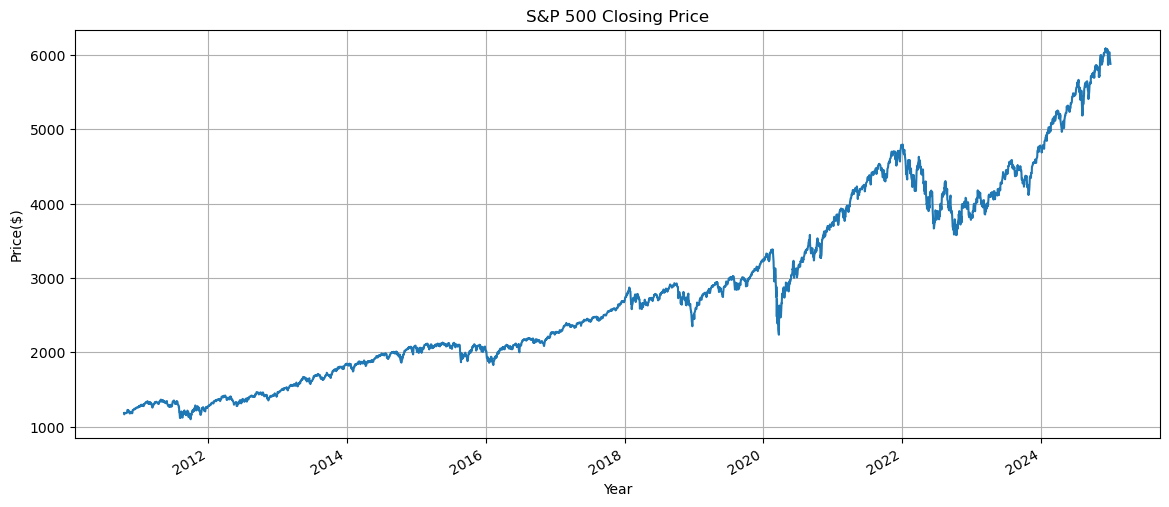

In [39]:
plt.figure(figsize=(14, 6))
df['Close'].plot(title='S&P 500 Closing Price')
plt.xlabel("Year")
plt.ylabel("Price($)")
plt.grid(True)
plt.show()

### Daily Returns
We calculate the daily percentage return of the S&P 500 using the `Close` price and examine its distribution.

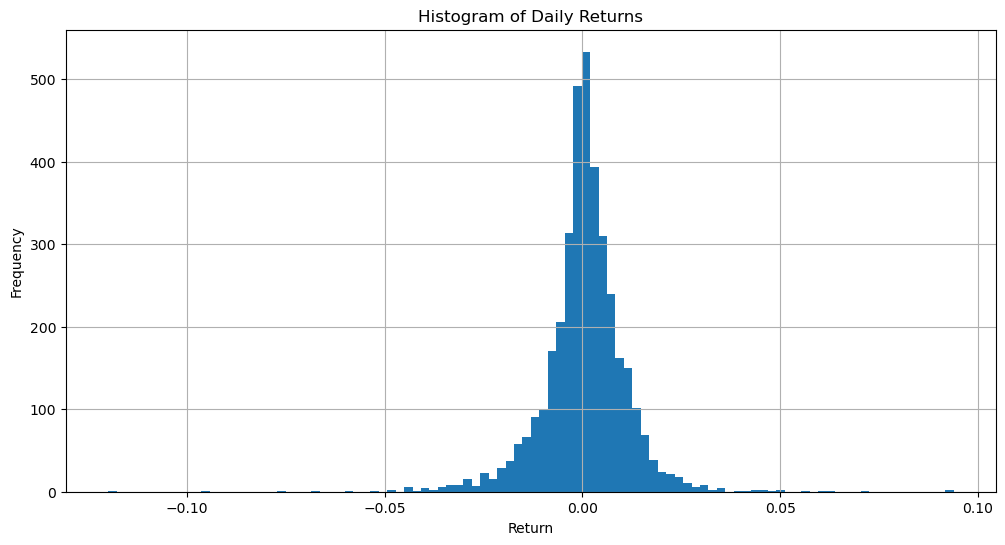

In [12]:
# Calculate daily return and plot histogram
df['Daily Return'] = df['Close'].pct_change()
df['Daily Return'].hist(bins=100, figsize=(12,6))
plt.title('Histogram of Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Rolling Volatility
Rolling volatility shows how the standard deviation of daily returns changes over time.

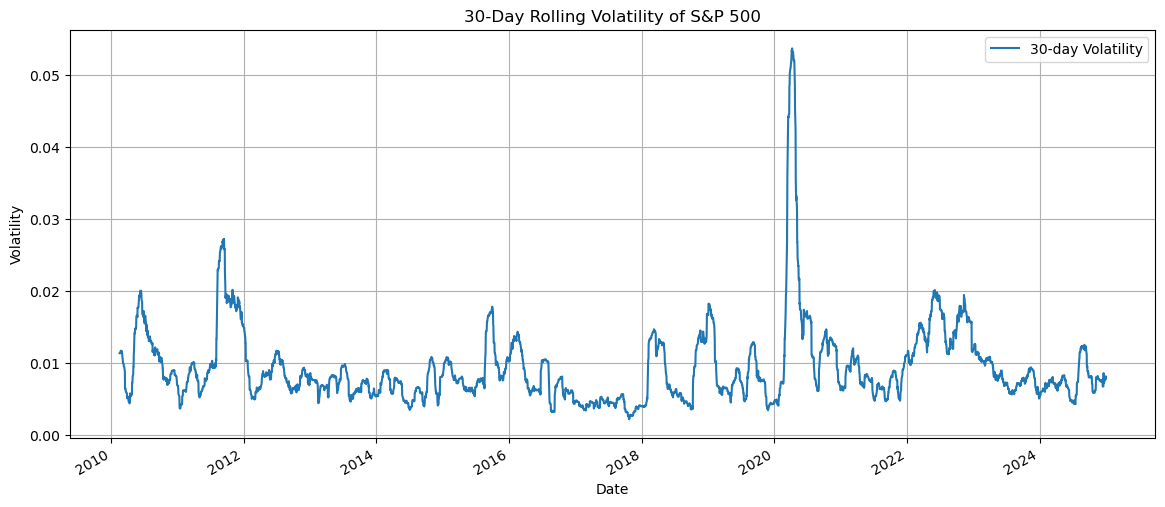

In [13]:
# 30-day rolling standard deviation
rolling_vol = df['Daily Return'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
rolling_vol.plot(label='30-day Volatility')
plt.title('30-Day Rolling Volatility of S&P 500')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.legend()
plt.show()

### Rolling Moving Averages
We compute 50-day and 200-day moving averages to identify long-term market trends.

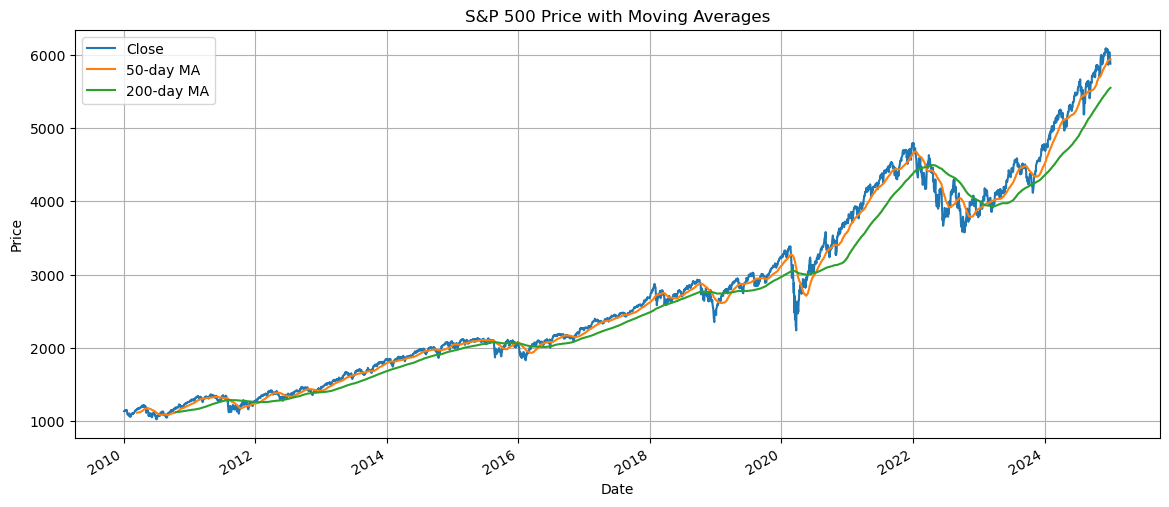

In [14]:
# Compute moving averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Plot
plt.figure(figsize=(14, 6))
df['Close'].plot(label='Close')
df['MA50'].plot(label='50-day MA')
df['MA200'].plot(label='200-day MA')
plt.title('S&P 500 Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.show()

## Data Exploration Insights

The S&P 500 data shows long-term upward momentum with some sharp corrections. This imbalance between upward and downward days suggests models might default to predicting “up,” which could inflate performance metrics.

Technical indicators like RSI, MACD, and Moving Averages behave as expected, but introduce `NaN` values at the beginning of the dataset. These early rows are removed to avoid leakage or instability in modeling.

Some indicators show delayed response to trend shifts. This will influence how we engineer features and define lag windows in later models.

# Model preprocessing

### Technical Indicators
Technical indicators help us capture price momentum, trend direction, and volatility. These are widely used by traders to make informed decisions. Below are some of the most common indicators:

- **RSI (Relative Strength Index):** Measures recent gains vs. losses over a 14-day window. Values >70 suggest overbought, <30 oversold.
- **MACD (Moving Average Convergence Divergence):** Compares short-term and long-term momentum via EMA crossovers.
- **Bollinger Bands:** Plots bands two standard deviations above and below a moving average.
- **Daily Return:** Percentage change in price from previous day (already added).


In [15]:
# RSI (Relative Strength Index)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Add RSI to DataFrame
df['RSI'] = compute_rsi(df['Close'])

In [16]:
# MACD (12-day EMA minus 26-day EMA)
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
# Signal line (9-day EMA of MACD)
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [17]:
# Bollinger Bands
rolling_mean = df['Close'].rolling(window=20).mean()
rolling_std = df['Close'].rolling(window=20).std()
df['Bollinger Upper'] = rolling_mean + (2 * rolling_std)
df['Bollinger Lower'] = rolling_mean - (2 * rolling_std)

### Labeling Market Movement
To train a model, we need labeled data. We'll classify the next day's movement as:
- **1** if the closing price went up
- **0** if the price went down or stayed the same

This binary label helps us frame the problem as a classification task.

In [18]:
# Create binary label for next-day price movement
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df['Target'].value_counts()

Target
1    2055
0    1719
Name: count, dtype: int64

### Data Cleaning

When calculating technical indicators like Moving Averages (MA), RSI, or MACD, it's **completely normal to encounter NaN values at the beginning of the dataset**.

This happens because these indicators rely on a **lookback window**. They need a minimum number of historical data points before they can return a result:

| Indicator       | Rows Needed |
|----------------|-------------|
| MA50            | 50 rows     |
| MA200           | 200 rows    |
| RSI (14)        | 14 rows     |
| MACD/Signal     | ~26+ rows   |
| Bollinger Bands | 20 rows     |

> For example, the 50-day moving average cannot be calculated until the 50th row. So rows 1 to 49 will be `NaN`.

These early NaNs should always be **dropped after feature engineering**. This is standard practice in financial modeling and avoids introducing noise or incorrect values.


In [19]:
# Drop rows with missing values caused by rolling indicators
print(f"Before dropping NaNs: {len(df)} rows")
df.dropna(inplace=True)
print(f"After dropping NaNs: {len(df)} rows")

Before dropping NaNs: 3774 rows
After dropping NaNs: 3575 rows


### Feature Selection and Normalization
Before feeding data into a machine learning model, we must:
1. Select relevant features (technical indicators)
2. Normalize them so all features contribute equally to model learning.

In [20]:
# Select features and target
features = ['RSI', 'MACD', 'Signal', 'Bollinger Upper', 'Bollinger Lower']
X = df[features].copy()
y = df['Target']

In [21]:
# Normalize features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

###  Train-Test Split
We split the dataset into training and testing sets to evaluate how the model performs on unseen data.

In [22]:
# Split data for modeling
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False  # no shuffle to preserve time order
)

# Model Training & Evaluation

### Interpreting Model Results

After training our models, we need to evaluate how well they perform. Not just in terms of raw accuracy, but whether they're actually making **useful financial predictions**.

#### Classification Report
The classification report includes:
- **Precision**: Of all predicted "up" (or "down") days, how many were actually correct?
- **Recall**: Of all actual "up" (or "down") days, how many did we correctly predict?
- **F1-score**: A balance between precision and recall. Useful when dealing with class imbalance.
- **Support**: The number of true instances for each class.

In market prediction, **precision** is often more important for buy signals (you want high confidence you're right), and **recall** is important if you're trying to avoid missing key opportunities.

#### Confusion Matrix
This table breaks down:
- **True Positives (TP)**: Correctly predicted up days
- **True Negatives (TN)**: Correctly predicted down days
- **False Positives (FP)**: Predicted "up" but was actually "down" (could mean loss)
- **False Negatives (FN)**: Predicted "down" but market went up (missed gain)

By interpreting this, we understand where the model is going wrong, and how risky it is to follow it.

## Logistic Regression Model
We'll start with a simple and interpretable model: **Logistic Regression**. It predicts the probability that the market goes up (Target = 1).

This will be our baseline model to compare, and we can see if future model can surpass this model at least.

In [23]:
# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [24]:
# Evaluate model performance
print("Accuracy:")
accuracy_score(y_test, y_pred)

Accuracy:


0.5202797202797202

In [25]:
# Clean version with zero_division fix and direct print
report = classification_report(y_test, y_pred, zero_division=0)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       343
           1       0.52      1.00      0.68       372

    accuracy                           0.52       715
   macro avg       0.26      0.50      0.34       715
weighted avg       0.27      0.52      0.36       715



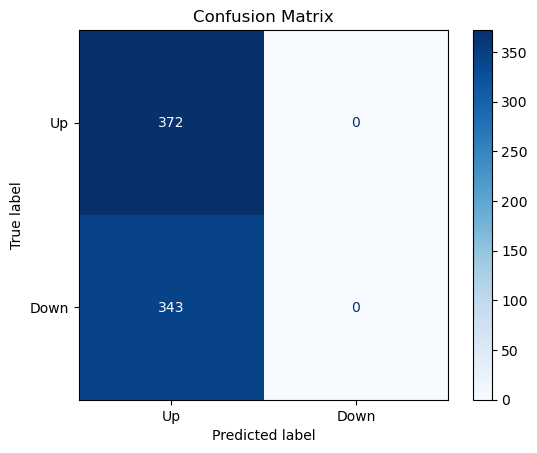

In [34]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Up", "Down"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

### Logistic Regression Evaluation

The logistic regression model predicted every test point as “up,” regardless of market reality. This is a typical baseline behavior in imbalanced financial data where the majority class dominates.

Despite this, the model achieved an accuracy close to the historical market trend of ~54 to 55 percent upward days. However, this isn't sufficient. A competent investment strategy must identify both entry and exit points with higher precision, especially during market downturns.

The model's inability to predict any down days makes it unsuitable for financial decision-making. Its performance reflects the need for more flexible algorithms that can capture non-linear trends and volatility.

## Random Forest Classifier
Now we'll train a **Random Forest**, a powerful ensemble method that often outperforms simple models by reducing overfitting and handling feature interactions.

In [27]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [28]:
# Evaluate Random Forest performance
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Accuracy: 0.4937062937062937


In [29]:
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.58      0.52       343
           1       0.52      0.42      0.46       372

    accuracy                           0.49       715
   macro avg       0.50      0.50      0.49       715
weighted avg       0.50      0.49      0.49       715



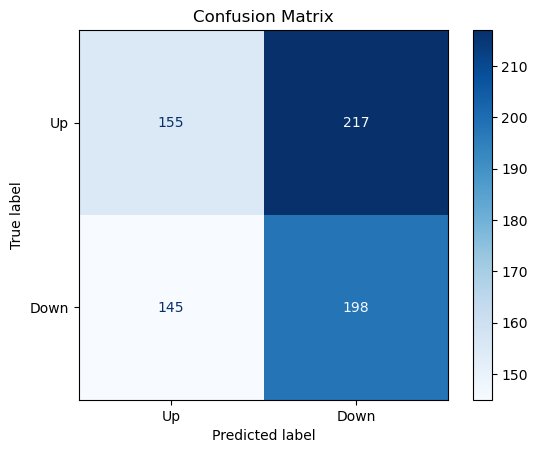

In [30]:
# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Up", "Down"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

### Random Forest Evaluation

Unlike logistic regression, which defaulted to predicting "up" for every sample, the random forest model produced a mix of "up" and "down" predictions. This already signals an improvement. It means the model is at least attempting to separate the classes based on signal from the features.

Still, the confusion matrix reveals a consistent bias: most down movements are misclassified. This shows that while the model handles more complexity, it's still not reliable in anticipating downturns.

The overall accuracy is higher than logistic regression, but not by a large margin. And recall for the down class remains weak. In financial terms, this could mean the model might perform decently in bull markets but exposes portfolios to significant downside risk in bear cycles.

In short, this is a better baseline, but not yet trade-worthy. We need smarter feature engineering or more advanced models like gradient boosting, along with improved evaluation strategies like time-based CV and realistic performance metrics (e.g. drawdown, Sharpe ratio) before calling it usable.

# Feature Engineering

Raw historical prices alone rarely offer enough signal for a predictive model. Markets are noisy, non-linear, and often driven by latent factors that are not directly observable in a single column like "Close" price. Feature engineering helps us extract meaningful patterns, trends, and behaviors from this raw data, making it easier for models to differentiate between upward and downward movements.

Good features can amplify the predictive signal in data, reduce noise, and help models understand momentum, volatility, and market cycles. Without this step, even advanced algorithms would be forced to learn from limited context (often leading to poor generalization and biased predictions). Well-designed features are the foundation of every robust financial machine learning system.

In [38]:
def generate_features(df):
    df = df.copy()

    # Lag features
    df['Close_lag_1'] = df['Close'].shift(1)
    df['Close_lag_5'] = df['Close'].shift(5)
    
    # Returns and momentum
    df['Daily_Return'] = df['Close'].pct_change()
    df['Weekly_Return'] = df['Close'].pct_change(5)
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

    # Rolling statistics
    df['MA_10'] = df['Close'].rolling(10).mean()
    df['STD_10'] = df['Close'].rolling(10).std()
    
    # Bollinger Bands
    df['Upper_Band'] = df['MA_10'] + 2 * df['STD_10']
    df['Lower_Band'] = df['MA_10'] - 2 * df['STD_10']
    
    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # MACD
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']

    # Volume
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_MA_5'] = df['Volume'].rolling(5).mean()
    df['Price_Volume'] = df['Close'] * df['Volume']

    # Price action
    df['High_Low'] = df['High'] - df['Low']
    df['Open_Close'] = df['Close'] - df['Open']

    # Calendar features
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter

    # Drop missing
    df.dropna(inplace=True)

    return df

featured_df = generate_features(df)
featured_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Daily Return',
       'MA50', 'MA200', 'RSI', 'MACD', 'Signal', 'Bollinger Upper',
       'Bollinger Lower', 'Target', 'Close_lag_1', 'Close_lag_5',
       'Daily_Return', 'Weekly_Return', 'Momentum_10', 'MA_10', 'STD_10',
       'Upper_Band', 'Lower_Band', 'RSI_14', 'EMA_12', 'EMA_26',
       'Volume_Change', 'Volume_MA_5', 'Price_Volume', 'High_Low',
       'Open_Close', 'DayOfWeek', 'Month', 'Quarter'],
      dtype='object')

### Breakdown and Explanation

- **Close_lag_1 & Close_lag_5**: Price from 1 and 5 days ago. These help models capture short-term momentum or reversion behavior.

- **Daily_Return & Weekly_Return**: Percent change in price over 1 and 5 days. These are foundational signals in quantitative finance, commonly used to track momentum.

- **Momentum_10**: Difference between today’s close and the close 10 days ago. A raw measure of price momentum.

- **MA_10 & STD_10**: 10-day moving average and standard deviation. They smooth out noise and give a clearer view of local trend and volatility.

- **Upper_Band & Lower_Band (Bollinger Bands)**: Define expected price range under normal volatility conditions. These can signal potential breakouts or overbought/oversold behavior.

- **RSI_14**: The 14-day Relative Strength Index is a classic momentum oscillator. It helps identify overbought and oversold conditions based on recent gains and losses.

- **MACD**: Difference between 12-day and 26-day exponential moving averages. This is a trend-following indicator that can capture shifts in market momentum.

- **Volume_Change & Volume_MA_5**: Show how current trading volume compares to recent history. Sudden spikes in volume can indicate strong buying or selling pressure.

- **Price_Volume**: Captures the product of price and volume to give a sense of capital flow.

- **High_Low & Open_Close**: Daily range and open-close difference help gauge intraday volatility and direction.

- **DayOfWeek, Month, Quarter**: Calendar effects can influence trading behavior. For example, Mondays may show reversal patterns or end-of-quarter periods might include institutional repositioning.

These features serve as a richer input set for our models, allowing them to better detect patterns and make more informed predictions.